# **REPORT**

# 1. COMPUTER VISION

# 2. GLOBAL PATH PLANNING

# 3. LOCAL OBSTACLE AVOIDANCE

# 4. KALMAN FILTERING FOR POSITION ESTIMATION
## a. Kalman Filter state space model

main source used: https://automaticaddison.com/how-to-derive-the-state-space-model-for-a-mobile-robot/

A state space model, also known as a state transition model, is a formula that describes how a robot moves from one point in time to the next. It illustrates the way a robot's location (such as its X and Y coordinates) and its direction (or yaw, represented by the angle $theta$) are influenced by adjustments to its control inputs.

We chosed to use $\begin{bmatrix} x \\ y \\ \theta \end{bmatrix}$ as the state vector for our differential drive robot. This are infact the quantities that the camera will be able to give us. The vectors refer to the global fixed reference and $theta$ is the angle with the positive direction of the x-axis. Since the only input is the velocity of the two wheels, the systems evolves accordingly to the following equatrions:

$$
\begin{bmatrix}
x_t \\
y_t \\
\theta_t
\end{bmatrix}
=
\begin{bmatrix}
x_{t-1} + v_{t-1} \cos \theta_{t-1} * Ts \\
y_{t-1} + v_{t-1} \sin \theta_{t-1} * Ts \\
\theta_{t-1} + \omega_{t-1} * Ts
\end{bmatrix}
=
\begin{bmatrix}
f_1 \\
f_2 \\
f_3
\end{bmatrix}
$$
The inputs considered are the ones taht we use to control it: $v$ and $\omega$, respectvely linear and angular velocity of the robot. The linear velociy has as direction the one indicated by the angle $\theta$. The controller will use hese quantities to execute the path following.
We then linearize in order to obtain a linearized state space model:

$$
A_{t-1} =
\begin{bmatrix}
\frac{\partial f_1}{\partial x_{t-1}} & \frac{\partial f_1}{\partial y_{t-1}} & \frac{\partial f_1}{\partial \theta_{t-1}} \\
\frac{\partial f_2}{\partial x_{t-1}} & \frac{\partial f_2}{\partial y_{t-1}} & \frac{\partial f_2}{\partial \theta_{t-1}} \\
\frac{\partial f_3}{\partial x_{t-1}} & \frac{\partial f_3}{\partial y_{t-1}} & \frac{\partial f_3}{\partial \theta_{t-1}}
\end{bmatrix}
$$


Matrix A relates the states of two consecutive sample is consequently an identity of the same dimension as the state. This is also the result of the above calculations since every function f_i depends linearly and with an unitary coefficient from the corrispondent variable:
$$ A = \begin{bmatrix} 1& 0 & 0\\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix} $$

Same thing we did about B matrix considering three partial derivatives with respect to velocity and angular velocity:

$$
B_{t-1} =
\begin{bmatrix}
\frac{\partial f_1}{\partial v_{t-1}} & \frac{\partial f_1}{\partial \omega_{t-1}} \\
\frac{\partial f_2}{\partial v_{t-1}} & \frac{\partial f_2}{\partial \omega_{t-1}} \\
\frac{\partial f_3}{\partial v_{t-1}} & \frac{\partial f_3}{\partial \omega_{t-1}}
\end{bmatrix}
$$


and so:

$$
B_{t-1} =
\begin{bmatrix}
\cos \theta_{t-1} * Ts & 0 \\
\sin \theta_{t-1} * Ts & 0 \\
0 & dt
\end{bmatrix}
$$

Finally, we added a process noise w with a Gaussian distribution with zero mean and covariance Q:
$$
\begin{bmatrix}
x_t \\
y_t \\
\theta_t
\end{bmatrix}
=
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
x_{t-1} \\
y_{t-1} \\
\theta_{t-1}
\end{bmatrix}
+
\begin{bmatrix}
\cos \gamma_{t-1} * Ts & 0 \\
\sin \gamma_{t-1} * Ts & 0 \\
0 & dt
\end{bmatrix}
\begin{bmatrix}
v_{t-1} \\
\omega_{t-1}
\end{bmatrix}
+
\begin{bmatrix}
w_{x_{t-1}} \\
w_{y_{t-1}} \\
w_{\theta_{t-1}}
\end{bmatrix}
$$


## b. Kalman Filter observation model
The observation model consists in predicting sensor measurements based on the estimated or predicted state of the system at the next timestep. Instead of directly translating raw sensor data into a state estimate, this model uses the current state prediction to forecast what the sensors should detect, creating a basis for comparison with actual sensor readings.
The observation model works by first using the state model to predict the state of the robot at that next timestep and then using that state prediction to infer what the sensor measurement would be at that point in time. 
This allows to then compute a weighted average (Kalman Filtering) of the predicted sensor measurements and the actual sensor observation at that timestep to create a better estimate of your state.

The measurements we obtain are the ones coming from the camera: position in terms of (x,y) coordinates and orientation ($\theta$ angle).
The general equation for the observation model is the following:
$$
y_t = H\cdot
\begin{bmatrix}
x\\
y\\
\theta
\end{bmatrix}
+
\begin{bmatrix}
v_{x_{t-1}} \\
v_{y_{t-1}} \\
v_{\theta_{t-1}}
\end{bmatrix}
$$

v is the measurement noise gaussianly distributed with zero mean and covariance matrix R.
The measurement matrix H is used to convert the predicted state estimate at time t into predicted sensor measurements at time t. In our case, H will be the identity matrix since the estimated state maps directly to sensor measurements [x, y, $\theta$]:
$$
H = 
\begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}


## c. Kalman Filter actual implementation
code derived from: https://automaticaddison.com/extended-kalman-filter-ekf-with-python-code-example/ 
code in Kal_FILTER.py

**Parameters choices**
*------------------------------------------------Q matrix: covariance matrix of process noise---------------------------------------------------------------------*

Given out 3-dimensional state $ \begin{bmatrix}
x  \\
y  \\
\theta
\end{bmatrix} $, the corresponding Q covariance matrix for the noise has the following structure:

$$ Q_k = \begin{bmatrix}
\text{Var}(x) & \text{Cov}(x,y) & \text{Cov}(x,\theta) \\
\text{Cov}(y,x) & \text{Var}(y) & \text{Cov}(y,\theta) \\
\text{Cov}(\theta,x) & \text{Cov}(\theta,y) & \text{Var}(\theta)
\end{bmatrix} $$


(consulted material: https://www.ucl.ac.uk/~ucfbpve/geotopes/indexch10.html) 

A measurement of the state is not available and we don't have any accurate sensors to do it. The way we chose to calculate Q related to the process relates to the Error Propagation Formula that relates the variance and covariance of a variable that depends upon other to the variances of the latters. \
In general, if $ t = f(X, Y)$

$$
\sigma^2_t = \begin{bmatrix}
\frac{\partial t}{\partial X} & \frac{\partial t}{\partial Y}
\end{bmatrix}
\begin{bmatrix}
\sigma^2_X & \text{cov}(X, Y) \\
\text{cov}(X, Y) & \sigma^2_Y
\end{bmatrix}
\begin{bmatrix}
\frac{\partial t}{\partial X} \\
\frac{\partial t}{\partial Y}
\end{bmatrix}
$$

In our case, the state space model we used toghether with the functions relating the inputs $v$ and $\omega$ to $v_r$ and $v_l$ give us the following discrete time relations:

$$
x_k=x_{\text{k+1}} + Ts \cdot R \cdot (\frac{v_r+v_l}{2})\cdot \cos(\theta_k) = f_1\\
y_k= y_{\text{k+1}} + Ts \cdot R \cdot (\frac{v_r+v_l}{2})\cdot \sin(\theta_k)= f_2\\
\theta_k=\theta_{\text{k+1}}= Ts \cdot R \cdot (\frac{v_r-v_l}{L}) = f_3
$$
where R represents the radius of the wheels and L the distance between them.




We can derive the following formulas:



**VARIANCE ESTIMATION**
$$ \sigma_x^2 = \left( \frac{\partial f_1}{\partial v_r} \right)^2 \sigma_{v_r}^2 + \left( \frac{\partial f_1}{\partial v_l} \right)^2 \sigma_{v_l}^2 + 2 \left( \frac{\partial f_1}{\partial v_r} \right) \left( \frac{\partial f_1}{\partial v_l} \right) \text{Cov}(v_r, v_l) $$

$$ \sigma_y^2 = \left( \frac{\partial f_2}{\partial v_r} \right)^2 \sigma_{v_r}^2 + \left( \frac{\partial f_2}{\partial v_l} \right)^2 \sigma_{v_l}^2 + 2 \left( \frac{\partial f_2}{\partial v_r} \right) \left( \frac{\partial f_2}{\partial v_l} \right) \text{Cov}(v_r, v_l) $$

$$ \sigma_\theta^2 = \left( \frac{\partial f_3}{\partial v_r} \right)^2 \sigma_{v_r}^2 + \left( \frac{\partial f_3}{\partial v_l} \right)^2 \sigma_{v_l}^2 + 2 \left( \frac{\partial f_3}{\partial v_r} \right) \left( \frac{\partial f_3}{\partial v_l} \right) \text{Cov}(v_r, v_l) $$

Since we can consider than the speeds on the two wheels are indipendent one on the other their covarianc is null:

$$\sigma_x^2 =  (\frac{Ts\cdot R}{2} \cos(\theta))^2 \cdot (\sigma_{V_r}^2+ \sigma_{V_l}^2)$$ 
$$\sigma_y^2 = (\frac{Ts\cdot R}{2} \sin(\theta))^2 \cdot (\sigma_{V_r}^2+\sigma_{V_r}^2)$$ 
$$\sigma_\theta^2 =  (\frac{Ts\cdot R}{L})^2 \cdot(\sigma_{V_r}^2+\sigma_{V_r}^2)$$


**COVARIANCE ESTIMATION**
$$
\text{Cov}(x, y) = \left( \frac{\partial f_1}{\partial v_r} \frac{\partial f_2}{\partial v_r} \right) \text{Var}(v_r) + \left( \frac{\partial f_1}{\partial v_l} \frac{\partial f_2}{\partial v_l} \right) \text{Var}(v_l) + \left( \frac{\partial f_1}{\partial v_r} \frac{\partial f_2}{\partial v_l} + \frac{\partial f_1}{\partial v_l} \frac{\partial f_2}{\partial v_r} \right) \text{Cov}(v_r, v_l)
$$

$$
\text{Cov}(x, \theta) = \left( \frac{\partial f_1}{\partial v_r} \frac{\partial f_3}{\partial v_r} \right) \text{Var}(v_r) + \left( \frac{\partial f_1}{\partial v_l} \frac{\partial f_3}{\partial v_l} \right) \text{Var}(v_l) + \left( \frac{\partial f_1}{\partial v_r} \frac{\partial f_3}{\partial v_l} + \frac{\partial f_1}{\partial v_l} \frac{\partial f_3}{\partial v_r} \right) \text{Cov}(v_r, v_l)
$$

$$
\text{Cov}(y, \theta) = \left( \frac{\partial f_2}{\partial v_r} \frac{\partial f_3}{\partial v_r} \right) \text{Var}(v_r) + \left( \frac{\partial f_2}{\partial v_l} \frac{\partial f_3}{\partial v_l} \right) \text{Var}(v_l) + \left( \frac{\partial f_2}{\partial v_r} \frac{\partial f_3}{\partial v_l} + \frac{\partial f_2}{\partial v_l} \frac{\partial f_3}{\partial v_r} \right) \text{Cov}(v_r, v_l)
$$

Hence,

$$
\text{Cov}(x, y) = (\frac{R}{2}\cdot Ts)^2 (\cos(\theta) \sin(\theta))(Var(v_r) + Var(v_l))\\

\text{Cov}(x, \theta) = \frac{(Ts\cdot R)^2}{2L} \cos(\theta)  (Var(v_r) - Var(v_l))\\

\text{Cov}(y, \theta) = \frac{(Ts\cdot R)^2}{2L} \sin(\theta) (Var(v_r) - Var(v_l))
$$
The covariance matrix is always symmetric.


From testing we measured the velocities of the two wheels as in the following graph:
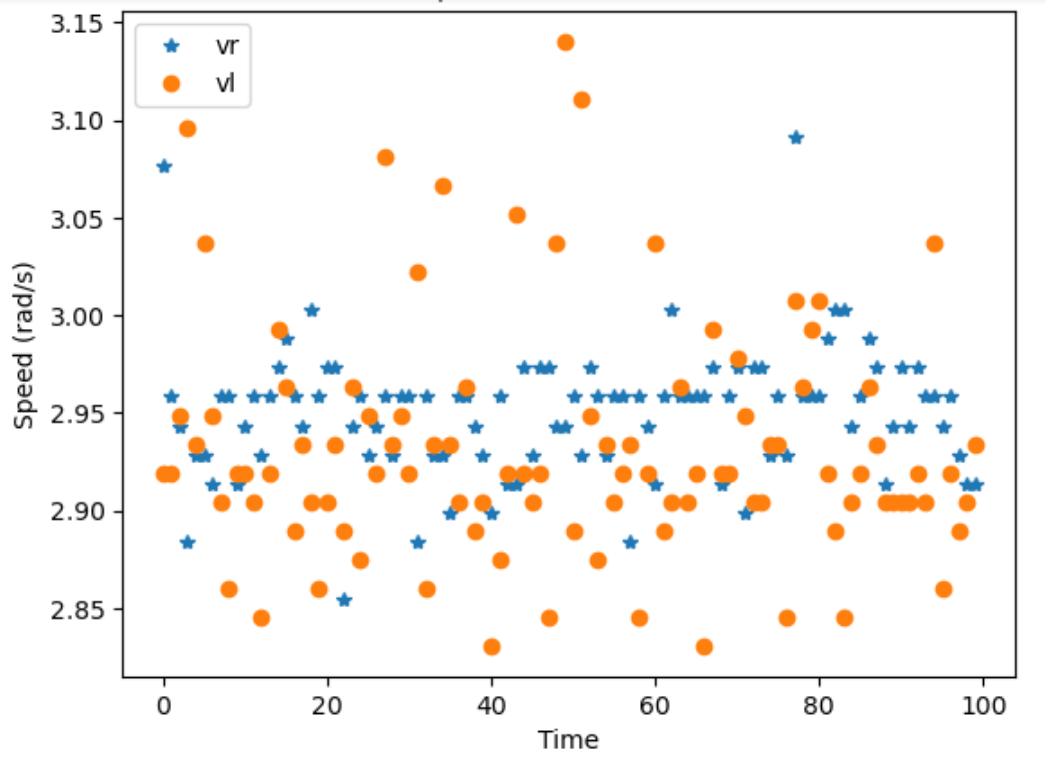

Then from the formulas of covariance and variance above, we calculated the entries of Q matrix for various angles:
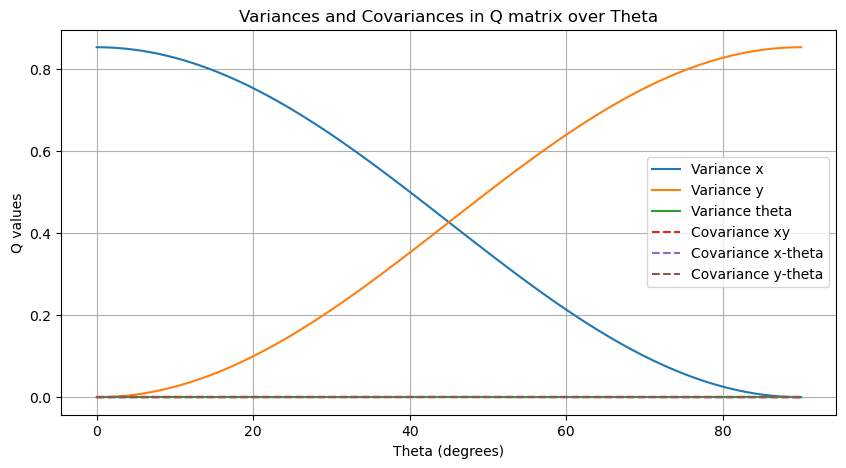

From the graph we can see that:
1. The covariances between theta and the other two variables are always negligible: these value depend in fact on the difference of the variance of the speed of the two wheels. Being it quasi-identical the two values fall down to zero.
2. Covariance between x and y is neglectible. In the mathematica formula we can in fact observe that the same function of $\theta$ is multiplied in this case by the same coefficient that in the variances of x and y but in this case in the denominator there is L which reduces the magnitude of teh coefficient. Moreover, the coefficient, smaller that 1, is also to thw second power and so it is further reduced.
3. Variance of theta is really smaller, quasi-null if compared to the variances of the other state variables. This is due againg to the coefficient which is smaller. 

Finally, we demonstrated that the covariance matrix of the process is diagonal.
Kalman Filter has as an assumption that Q matrix is not depedent on the state. We decided to use tha maximum value for each variance and covariance in order to never overestimate the capabilities of the state predictions.

$$
Q= 
\begin{bmatrix}
0.85382 & 0 & 0\\
0 & 0.85382 & 0\\
0 &0 & 0.00032
\end{bmatrix}
$$


*-----------------------------------------------R matrix: covariance matrix of measurement noise----------------------------------------------------------------*
**TODO**

*-----------------------------------------------Convertion factors for wheels velocities-------------------------------------------------------------------------*


The goal is to convert the velocity of rotation of the wheels units from rad/s to the Thymio ones. Controller in fact will have as an input $v_r$ and $v_l$ in rad/s but will output them in Thymio Units to the plant.

<table><tr> 
<td> <img src="photo_2023-11-23_20-33-54.jpg" alt="photo_2023-11-23_20-33-54" style="width: 250px;"/> </td> 
 
</tr></table>

We used a code that counts the time untill one presses the central button. So, one person counts a certain amount of rounds and sign the number counted in the variable num_rotations. Then with some simple counts given the number of rotations and the time needed to do it, the velocity of rotation is calculated. The final coefficient is the average of the coefficients extracted.
In order to actually count the number of rounds we drew a green mark on the wheel.

The results are summarized in the following picture:
![Alt text](image.png)

*----------------------------------------------- Velocity conversion: from $v_r$ and $v_l$ to $v$ and $\omega$------------------------------------------------------*
https://www.cs.columbia.edu/~allen/F17/NOTES/icckinematics.pdf 

Linear velocity is the average of the speeds of the two wheels.
$ v = R\cdot \frac{v_{\text{r}} + v_{\text{l}}}{2}  $

Angular velocity depends on the difference in speed of the two wheels and the distance between them (wheelbase). If L is the distance between the centers of the two wheels, then:
$\omega = R \cdot\frac{v_{\text{r}} - v_{\text{l}}}{L} $ 


Given that we obtain:

$v_{r} = \frac{2v+\omega L}{2R}$ ,

$v_{l} = \frac{2v-\omega L}{2R}$

Consult the python code of the controller for the detailed definition of these functions


# CONTROLLER FOR PATH FOLLOWING


# Main code

In [1]:
#Global variables
state = 0
obst = [0,0,0,0,0]
motors_speed = [0,0]
not_arrived = True
k = 0
C_conv_toThymio_right = 67.60908181
C_conv_toThymio_left = 67.82946137
L = 95 #mm
R = 23 #mm
Ts = 0.5 # sampling time
# Initial state covariance matrix
P_k_minus_1 = np.array([[0.1, 0, 0],
                        [0, 0.1, 0],
                        [0, 0, 0.1]])
P_k = P_k_minus_1
threshold_for_convergence = 20
threshold_for_convergence_local = 100
speed0 = 60
speedGain = 30

path = []
while True:
    if state == 0:
        # Create an adjusted dictionary of 5 markers of 4x4 bits.
        aruco_dictionary = cv2.aruco.extendDictionary(5, 4)
        # Assign a marker to each objects to be recognized on the map
        # Generate three reference markers
        detector = create_detector(aruco_dictionary)
       

        for i in range(5):
            marker = cv2.aruco.generateImageMarker(aruco_dictionary, i, 500, np.zeros((6, 6, 1), dtype="uint8"), 1)
            cv2.imwrite('marker' + str(i) +'.jpg', marker)
        # Definition of the references used to map the space
        ref1 = Obj(0, np.array([[0,0]]))
        ref2 = Obj(1, np.array([[0,0]]))
        ref3 = Obj(2, np.array([[0,0]]))

       
        # Definition of the objects to recognize in the space
        goal = Obj(3, np.array([[]]))
        thymio = Obj(4, np.array([[]]))

        map = Map(ref1,ref2,ref3,920,660)

        objects = np.array([ref1,ref2, ref3, goal, thymio])

        # Open the video
        # For a livestream
        video = cv2.VideoCapture(0)
        # or with a prerecorded video
        #video = cv2.VideoCapture('test3.avi')
        if (video.isOpened()== False): 
            print("Error opening video stream or file")
        
        # Recognition of the view with the map and path planning
        path_found = False
        while not (path_found):
            ret, frame = video.read()
            if ret == True:
                clear_output(wait=True)
                show_frame(frame)

                detect_objects(frame, detector, objects)
                if map.references_detected():
                    print('Goal position', map.localize(goal))
                    matrix = map.matrix(frame, thymio, goal)

                    if check_matrix(matrix):
                        path, visitedNodes = global_path(matrix)
                        print_path(matrix, path, visitedNodes)
                        path = np.multiply(path, 50)
                        N = np.size(path,1)
                        path_found = True
                        state_estimate_k = np.array([map.localize(thymio)[0][0],map.localize(thymio)[0][1],-vector_to_angle(map.vec_img2map(thymio.get_img_dir()[0]))])

        # Navigation
        state = 1    
        # Global navigation state
    if state == 1:
    
        while not_arrived == True:

            #Check if there is obstacles
            prox_horizontal = local.read_prox_sensors(node,client)
            obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
            state = local.update_state(state,obst,client)
            if state == 2:
                break

            # Path following: control law
            print("Position final goal", [path[0,k],path[1,k]])
            vr, vl = mctrl.control_law(state_estimate_k, path[0,k], path[1,k],speed0,speedGain)
            #control_vector_k_minus_1 = mctrl.convert_velocity2vw(vr,vl,C_conv_toThymio_right, C_conv_toThymio_left,L,R) if we use [v,w] as control variables in state space model
            control_vector_k_minus_1 = np.array([vr/C_conv_toThymio_right,vl/C_conv_toThymio_left]) #if we use [vr,vl] as control variables in state space model
            print("Control vector", control_vector_k_minus_1)
            mctrl.set_motors(vl,vr,node)
            
            
            # Take Thymio position if camera is not obstructed and update state estimate with kalman filter
            if video.isOpened:
                ret, frame = video.read()
                new_frame = frame.copy()
                if ret == True:
                    
                    #clear_output(wait=True)
                    detect_objects(frame, detector, objects)
                    
                    ref1.draw(new_frame, [255,0,0])
                    ref2.draw(new_frame, [0,255,0])
                    ref3.draw(new_frame, [0,0,255])
                    goal.draw(new_frame, [255,255,255])
                    thymio.draw(new_frame, [255,0,0])
                    #show_frame(new_frame)
                    
                    
                    if map.references_detected(): #camera correctly working
                        camera_obstructed = 0

                        if np.size(map.localize(thymio), 0) > 0: #camera working correctly
                            #take robot position from camera
                            z_k_observation_vector = np.array([map.localize(thymio)[0][0],map.localize(thymio)[0][1],-vector_to_angle(map.vec_img2map(thymio.get_img_dir()[0]))])  
                            print("Robot position and angle (rad)", z_k_observation_vector)  
                            # update state estimate with kalman filter
                            #state_estimate_k = z_k_observation_vector #if you don't use kalman filter
                            state_estimate_k,P_k_minus_1 = kfil.ekf(z_k_observation_vector, state_estimate_k, control_vector_k_minus_1, P_k_minus_1, Ts, camera_obstructed)
                            print("State_estimate_k", state_estimate_k)
                            print("temporary goal: ", [path[0,k], path[1,k]])   
                    else: #camera obstructed
                        camera_obstructed = 1
                        print("WARNING:NOCAMERA--WARNING:NOCAMERA--WARNIN:NOCAMERA--WARNING:NOCAMERA")
                        #Measurements are not updated by camera but only by kalman filter
                        state_estimate_k,P_k_minus_1 = kfil.ekf(z_k_observation_vector, state_estimate_k, control_vector_k_minus_1, P_k_minus_1, Ts, camera_obstructed) 
                        print("State_estimate_k", state_estimate_k)
                        print("temporary goal: ", [path[0,k], path[1,k]])

            # Check if the robot has arrived to the temporary goal
            if np.linalg.norm(state_estimate_k[:2] - np.array([path[0,k], path[1,k]])) < threshold_for_convergence:
                if k >= N-1:
                    not_arrived = False
                    print('The robot has arrived to the final goal')
                    mctrl.stop_motors(node)
                    #break

                elif k + N//8 < N-1:
                    k = k + N//8 # go to the next temporary goal 
                else:
                    k = N-1   # go to the final goal
                print("position {} of {} in path: ".format(k,N-1))
                

 
            time.sleep(Ts)   


    # Local navigation state
    if state == 2:         
        #We get the sensor value
        prox_horizontal = local.read_prox_sensors(node,client)
        
        #We fill the obst list with the sensor value
        obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
        
        #We calculate the motor speed to avoid the object -> potential field method
        motors_speed = local.local_navigation(obst)
        
        #We set the motor speed
        mctrl.set_motors(motors_speed[0],motors_speed[1],node)       
        #We update the state
        state = local.update_state(state,obst,client)
        if state == 1:
            vr = speed0
            vl = speed0
            mctrl.set_motors(vl,vr,node)
            if k + 40 < N-1:
                k = k+40
            else: 
                k = N-10
            print("koala")
             
            

       


NameError: name 'np' is not defined